Tf-Idf + Logistic regression is a very nice baseline for many tasks. Here we'll briefly explore the given dataset and then we'll build a simple baseline based on Tf-Idf representations of product reviews.

In [1]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
from matplotlib import pyplot as plt
import seaborn as sns
import eli5

In [4]:
train = pd.read_csv('../input/train.csv', index_col='id').fillna(' ')
valid = pd.read_csv('../input/valid.csv', index_col='id').fillna(' ')
test = pd.read_csv('../input/test.csv', index_col='id').fillna(' ')

In [5]:
train.head()

,text,label
id,,
0,Sam has an everlast treat each nite before bed...,dogs
1,The product is as it says. I keep an eye on it...,dogs
2,My Kitty thinks these are treats! He loves the...,dogs
3,This is the third or fourth time that we've or...,dogs
4,Put this on both my dogs. And they are scratch...,dogs


We'll be validating with train + validation files.

In [6]:
train_val = pd.concat([train, valid])

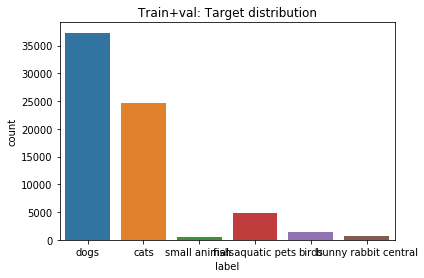

In [7]:
sns.countplot(train_val['label']);
plt.title('Train+val: Target distribution');

We can see that test texts are in general shorter.

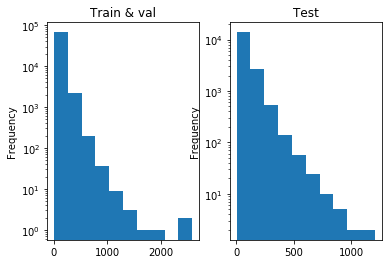

In [9]:
plt.subplots(1, 2)
plt.subplot(1, 2, 1)
train_val['text'].apply(lambda x: len(x.split())).plot(kind='hist');
plt.yscale('log');
plt.title('Train & val');
plt.subplot(1, 2, 2)
test['text'].apply(lambda x: len(x.split())).plot(kind='hist');
plt.yscale('log');
plt.title('Test');

As an entertainment, we can build a wordcloud for reviews. However, no useful insights from such pictures.

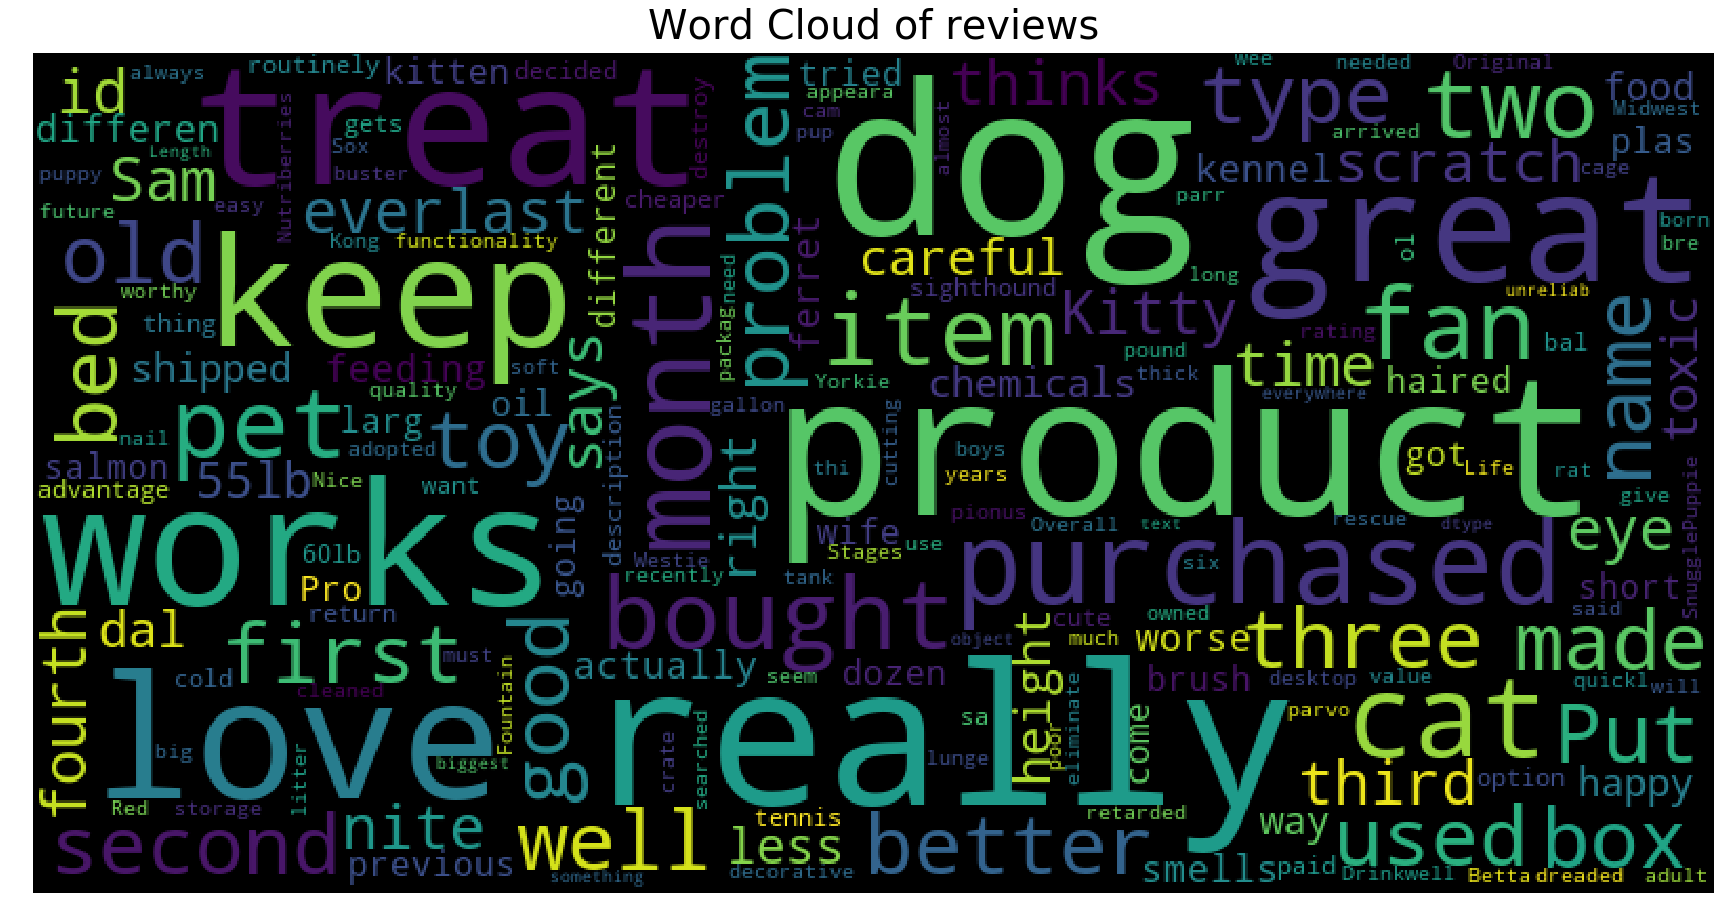

In [10]:
from wordcloud import WordCloud, STOPWORDS

# Thanks : https://www.kaggle.com/aashita/word-clouds-of-various-shapes ##
def plot_wordcloud(text, mask=None, max_words=200, max_font_size=100, figure_size=(24.0,16.0), 
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)
    more_stopwords = {'one', 'br', 'Po', 'th', 'sayi', 'fo', 'Unknown'}
    stopwords = stopwords.union(more_stopwords)

    wordcloud = WordCloud(background_color='black',
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    width=800, 
                    height=400,
                    mask = mask)
    wordcloud.generate(str(text))
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  
    
plot_wordcloud(train_val["text"], title="Word Cloud of reviews")

We'll be using a Tf-Idf vectorizer.

In [11]:
text_transformer = TfidfVectorizer(stop_words='english', ngram_range=(1, 2), lowercase=True, max_features=150000)

In [12]:
%%time
X_train_text = text_transformer.fit_transform(train_val['text'])
X_test_text = text_transformer.transform(test['text'])

CPU times: user 19.8 s, sys: 500 ms, total: 20.3 s
Wall time: 20.3 s


In [13]:
X_train_text.shape, X_test_text.shape

((69410, 150000), (17353, 150000))

As for the model, let's simply pick logistic regression.

In [14]:
logit = LogisticRegression(C=5e1, solver='lbfgs', multi_class='multinomial', random_state=17, n_jobs=4)

**Cross-validation**

In [15]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)

In [17]:
%%time
cv_results = cross_val_score(logit, X_train_text, train_val['label'], cv=skf, scoring='f1_micro')

CPU times: user 1.42 s, sys: 280 ms, total: 1.7 s
Wall time: 2min 58s


In [18]:
cv_results, cv_results.mean()

(array([0.83601008, 0.828627  , 0.83907218, 0.83495425, 0.83645533]),
 0.8350237694088513)

It's nice to see that cross-validation is more or less stable across folds. Let's train the model on train + val.

In [19]:
%%time
logit.fit(X_train_text, train_val['label'])

CPU times: user 108 ms, sys: 24 ms, total: 132 ms
Wall time: 36.5 s


LogisticRegression(C=50.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=4, penalty='l2', random_state=17, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

**Trying to interpret model weights with ELI5 - look reasonable.**

In [20]:
eli5.show_weights(estimator=logit, 
                  feature_names= list(text_transformer.get_feature_names()),
                 top=(50, 5))

**Preparing submission.**

In [21]:
test_preds = logit.predict(X_test_text)

In [22]:
pd.DataFrame(test_preds, columns=['label']).head()

,label
0,fish aquatic pets
1,dogs
2,dogs
3,dogs
4,cats


In [23]:
pd.DataFrame(test_preds, columns=['label']).to_csv('logit_tf_idf_starter_submission.csv',
                                                  index_label='id')

**What you can try next**

 - tune hyperparams, those of `TfIdfVectorizers` as well
 - add Word2Vec/GloVE/Fasttext embeddings, at least for titles
 - switch to ULMFiT and other heavy stuff
 